<a href="https://colab.research.google.com/github/nouvalhs/image_captioning/blob/main/Code_LSTM_CNN_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Koneksi ke GDRIVE

Hal ini dilakukan agar dapat terhubung dengan data yang akan diproses dalam pemodelan.

In [ ]:
#Code untuk connect to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Memasukan Modul 

Memasukan modul yang digunakan untuk memproses data dalam pemodelan.

In [ ]:
# Import all libraries
import numpy as np
from numpy import array

import pandas as pd

from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

import random
import string
import os
from PIL import Image
import glob

import pickle
from pickle import dump, load
from time import time
from IPython.display import Image, display
from IPython.core.display import display, HTML

from keras import Input, layers
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization
from keras.layers import Flatten, Input, Convolution2D, TimeDistributed, Bidirectional
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential, Model
from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.models import load_model

## Memasukan Data

Dalam hal ini melakukan akses data ke Gdrive

In [ ]:
#Load data
images_dir = os.listdir("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/")

images_path = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Images/"
captions_path = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

#Pembagian data menjadi data train, data validasi dan data test
train_path = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt"
val_path = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt"
test_path = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"

#membuka data 
captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
#Melihat data pertama dari captions, x_train
display(captions[0])
display(x_train[0])
display(x_val[0])
display(x_test[0])

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

'2513260012_03d33305cf.jpg'

'2090545563_a4e66ec76b.jpg'

'3385593926_d3e9c21170.jpg'

## Melihat Sampel Data

- Membuka data sebagai dictionary dimana gambar sebagai key dan caption sebagai value
- Melihat salah satu data yang sudah dibentuk menjadi dictionary 
- Terkait dataset: 1 gambar diberikan deskripsi oleh 5 responden 

In [ ]:
# Loading captions as values and images as key in dictionary
tokens = {}
for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

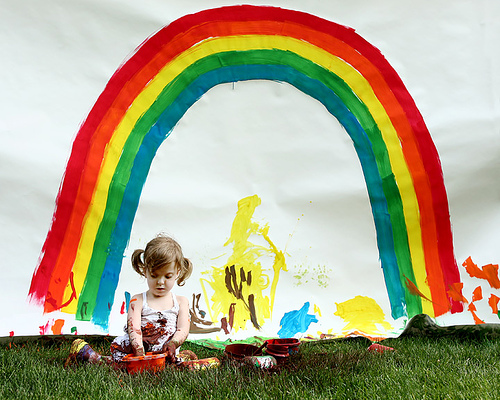

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [ ]:
# displaying an image and captions given to it
temp = captions[10].split("#")
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

## Membagi Data

- Pembagian data untuk pemodelan dibagi menjadi data train, data validasi, dan data test. 
- Pembagian data ini berdasarkan hasil data yang sudah dibuat menjadi dictionary tadi

In [ ]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

## Hasil Membagi Data

- Data disimpan dalam suatu tempat/wadah terbuka
- Kemudian tempat/wadah tersebut ditutup



In [ ]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [ ]:
display(train_dataset)
display(test_dataset)
display(val_dataset)

<_io.BufferedWriter name='/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_train_dataset.txt'>

<_io.BufferedWriter name='/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_test_dataset.txt'>

<_io.BufferedWriter name='/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_val_dataset.txt'>

## Mendefinisikan Model

Dalam hal ini mendefinisikan model dan menampilkan hasil ringkasan model yang telah dibuat (Membangun Arsitektur). 


##### Catatan: Model yang digunakan adalah ResNet50

In [ ]:
# Loading 50 layer Residual Network Model and getting the summary of the model
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

# Note: For more details on ResNet50 architecture you can click on hyperlink given below

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

## Data Pre-Processing

Pre-processing yang dilakukan dalam pengolahan data ini yaitu:
- Resize gambar menjadi ukuran target yang ada pada data train 

Bisa langsung ke tahap ini jika telah mempunyai file data train

In [ ]:
with open( "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/train_encoded_images.p", "rb" ) as pickle_f:
    train_data = pickle.load(pickle_f)

In [ ]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

In [ ]:
# opening train_encoded_images.p file and dumping it's content
with open( "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f)

## Membuka Hasil Data Pre-Processing

- Membuka data train
- Menampilkan data train
- Melihat ukuran data train

In [ ]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
#melihat 10 data pertama dari data train
pd_dataset.head(10)

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...
5,2903617548_d3e38d7f88.jpg,<start> A little baby plays croquet . <end>
6,2903617548_d3e38d7f88.jpg,<start> A little girl plays croquet next to a ...
7,2903617548_d3e38d7f88.jpg,<start> The child is playing croquette by the ...
8,2903617548_d3e38d7f88.jpg,<start> The kid is in front of a car with a pu...
9,2903617548_d3e38d7f88.jpg,<start> The little boy is playing with a croqu...


- Menyimpan data yang ada pada kolom caption menjadi list
- Melihat ukuran kolom caption
- Menampilkan salah satu isi dari kolom caption

In [ ]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))
print(sentences[0])

30000
<start> A black dog is running after a white dog in the snow . <end>


- Melihat 5 data yang ada pada kolom caption
- Men-split data yang ada pada kolom caption kemudian disimpan dalam list of the list

In [ ]:
# First 5 captions stored in sentences
display(sentences[:5])

# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]
words[:2]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

[['<start>',
  'A',
  'black',
  'dog',
  'is',
  'running',
  'after',
  'a',
  'white',
  'dog',
  'in',
  'the',
  'snow',
  '.',
  '<end>'],
 ['<start>',
  'Black',
  'dog',
  'chasing',
  'brown',
  'dog',
  'through',
  'snow',
  '<end>']]

- Membuat list dari semua kata-kata unik
- Kata unik disini artinya kata yang tidak sama 

In [ ]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


## Membuat Vektor Kata-Kata

- Membuat index untuk semua kata-kata unik di himpunan vocab
- Membuat transpose datanya dalam hal ini kata-kata unik dipadankan dengan indexnya 

PR 
- Validasi index dari angka berapa untuk vocab ?

In [ ]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique,1)}
indices_2_word = {index:val for index, val in enumerate(unique,1)}

word_2_indices['UNK'] = 0
#word_2_indices['raining'] = 8254

indices_2_word[0] = 'UNK'
#indices_2_word[8254] = 'raining'

print(word_2_indices['<start>'])
print(indices_2_word[4011])

print(word_2_indices['<end>'])
print(indices_2_word[8051])

vocab_size = len(word_2_indices.keys())
print(vocab_size)

1700
ridge
3459
focuses
8254


- Memeriksa maksimum panjang caption yang ada pada setiap kalimat

In [ ]:
max_len = max([len(i.split()) for i in sentences])
print(max_len)

with open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/max_len_sentence.p', 'wb') as f:
    pickle.dump(max_len,f)

40


In [ ]:
with open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/train_encoded_images.p', 'wb') as f:
    pickle.dump(word_2_indices,f)

- Menambahkan nilai dummy
- Membangkit kata kembali

In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

print(padded_sequences[0])

(30000,)
(30000,)
[[1700    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1700 6280    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1700 6280 3454    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1700 6280 3454 7435    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1700 6280 3454 7435 2425    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    

- 

In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

num_of_images = 2000

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

- Menggabungkan captions dengan kata selanjutnya
- 

In [ ]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

# save the name
np.save("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/captions.npy", captions)
np.save("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/next_words.npy", next_words)

# Check the dimensions
print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


Jika sudah memliki caption.npy dan next word.np bisa langsung ke isni

In [ ]:
caption = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/captions.npy")
next_word = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/next_words.npy")

In [ ]:
with open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/vocab.p', 'rb') as f:
    word_2_indices = pickle.load(f)

indices_2_word = {index:val for val, index in word_2_indices.items()}
vocab_size = len(word_2_indices)

In [ ]:
with open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        #print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0]]))
imgs = np.asarray(imgs)
print(imgs)

[[0.4052755  1.1592709  0.27029932 ... 0.41691053 0.         0.34826237]
 [0.4052755  1.1592709  0.27029932 ... 0.41691053 0.         0.34826237]
 [0.4052755  1.1592709  0.27029932 ... 0.41691053 0.         0.34826237]
 ...
 [0.0411736  1.1419293  0.06949896 ... 0.07303671 1.2326471  1.6955845 ]
 [0.0411736  1.1419293  0.06949896 ... 0.07303671 1.2326471  1.6955845 ]
 [0.0411736  1.1419293  0.06949896 ... 0.07303671 1.2326471  1.6955845 ]]


In [ ]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/images.npy", images)

print(images.shape)

(25493, 2048)


In [ ]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/image_names.npy", image_names)

print(len(image_names))

25493


In [ ]:
captions = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/captions.npy")
next_words = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
images = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/images.npy")

print(images.shape)

(25493, 2048)


In [ ]:
imag = np.load("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/image_names.npy")
        
print(imag.shape)

(25493,)


In [ ]:
embedding_size = 128
with open('/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/max_len_sentence.p', 'rb') as f:
    max_len = pickle.load(f)

In [ ]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

#model.load_weights("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
______________________________________________________________________________________

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
50/50 [==============================] - 10s 200ms/step - loss: 5.5563 - accuracy: 0.1190
Epoch 2/200
50/50 [==============================] - 10s 196ms/step - loss: 4.7592 - accuracy: 0.2113
Epoch 3/200
50/50 [==============================] - 10s 197ms/step - loss: 4.4347 - accuracy: 0.2387
Epoch 4/200
50/50 [==============================] - 10s 197ms/step - loss: 4.1374 - accuracy: 0.2614
Epoch 5/200
50/50 [==============================] - 10s 197ms/step - loss: 3.8838 - accuracy: 0.2829
Epoch 6/200
50/50 [==============================] - 10s 197ms/step - loss: 3.6534 - accuracy: 0.3047
Epoch 7/200
50/50 [==============================] - 10s 198ms/step - loss: 3.4663 - accuracy: 0.3221
Epoch 8/200
50/50 [==============================] - 10s 198ms/step - loss: 3.2774 - accuracy: 0.3433
Epoch 9/200
50/50 [==============================] - 10s 198ms/step - loss: 3.1106 - accuracy: 0.3603
Epoch 10/200
50/50 [==============================] - 10s 198ms/step - loss: 2.951

In [ ]:
plt.plot(hist.history["accuracy"])
plt.xlabel("# Number of Epochs")
plt.ylabel("The Accuracy")
plt.title("Number of Epochs vs Accuracy")
plt.show()

plt.plot(hist.history["loss"])
plt.xlabel("# Number of Epochs")
plt.ylabel("The Loss")
plt.title("Number of Epochs vs Loss")
plt.show()

In [ ]:
model.save_weights("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/model_weights.h5")

In [ ]:
model.save("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/model.h5")

In [ ]:
model = load_model("/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Result/model.h5")

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
img = ["/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Images/1453366750_6e8cf601bf.jpg"
img = "/content/drive/My Drive/RepSession_DSI/Data_Image_Captioning_Flickr8K/Flickr_Data/Images/2090545563_a4e66ec76b.jpg"

test_img = get_encoding(resnet, img)

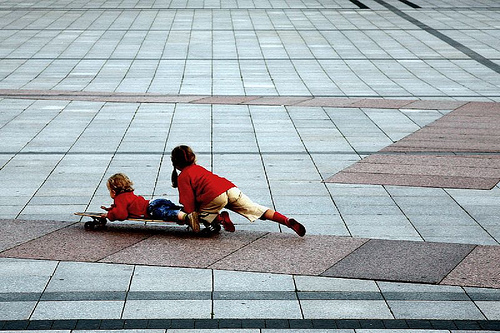

A young girl in a black shirt is playing on a wall .


In [ ]:
Argmax_Search = predict_captions(test_img)
z = Image(filename=img)
display(z)

print(Argmax_Search)